In [1]:
from IPython.display import display, HTML

# Hide code cells for user experience
def hide_code():
    hide_css = '''
    <style>
        .jp-CodeCell .jp-InputArea { display: none !important; }
        .jp-MarkdownCell .jp-InputArea { display: block !important; }
    </style>
    '''
    display(HTML(hide_css))

hide_code()

# Smoking Status Prediction for Extension Insurance Co.

# Gregory Nowotarski

# Project Objectives

1. Predict smoking status based on multiple biosignals and demographic factors.
2. Improve upon the baseline model's prediction accuracy through:
   - In-depth data analysis
   - Feature engineering
   - Model tuning and optimization
3. Develop an interactive tool for smoking status prediction.

### Key Metrics:
- Improve accuracy, precision, recall, F1-score, and ROC-AUC over the baseline model.
- Achieve a balance between model performance and interpretability.

## Table of Contents

1. [Project Objectives](#Project-Objectives)
2. [Data Discovery](#Data-Discovery)
3. [Data Initial Preprocessing](#Data-Initial-Preprocessing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Baseline Model Comparison and Evaluation](#Baseline-Model-Comparison-and-Evaluation)
6. [Understanding the Chosen ML Algorithm - Random Forest Model](#Understanding-the-Chosen-ML-Algorithm-Random-Forest-Model)
6. [Feature Engineering and Tuning the Best Model](#Feature-Engineering-and-Tuning-the-Best-Model)
7. [Best Model Analysis and Comparison](#Best-Model-Analysis-and-Comparison)
8. [Smoking Status Prediction Tool](#Smoking-Status-Prediction-Tool)

In [2]:
# Core Data Manipulation and Analysis
import pandas as pd
import numpy as np
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Visualization
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Jupyter Widgets and Display
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Additional Utilities
from joblib import load

In [3]:
# Load pre-trained models to prevent training bottlenecks
baseline_rf = load(os.path.join('models', "baseline_rf.joblib"))
best_model = load(os.path.join('models', "best_rf_model_after_feature_engineering.joblib"))
lr = load(os.path.join('models', "lr.joblib"))

# Load dataset
df = pd.read_csv('data/smokingdata.csv')

## Data Discovery

In [4]:
# Display the shape of the dataset
display(HTML("<h4>Shape of the Dataset:</h3>"))
display(HTML(f"<p>{df.shape}</p>"))

# Display column names
display(HTML("<h4>Column Names:</h3>"))
display(HTML(f"<p>{', '.join(df.columns.tolist())}</p>"))

# Display data types of each column
display(HTML("<h4>Data Types of Each Column:</h3>"))
data_types_df = df.dtypes.to_frame().reset_index()
data_types_df.columns = ['Column', 'Data Type']
display(data_types_df)

# Display the first few rows
display(HTML("<h4>First Few Rows of the Dataset:</h3>"))
display(df.head())

,Column,Data Type
0,ID,int64
1,gender,object
2,age,int64
3,height(cm),int64
4,weight(kg),int64
5,waist(cm),float64
6,eyesight(left),float64
7,eyesight(right),float64
8,hearing(left),float64
9,hearing(right),float64


,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


### Takeaways from Data Discovery:

- **Dataset shape**: 55,692 rows and 27 columns
- Mix of numeric and categorical variables including health metrics and lifestyle factors
- **Key features**: age, gender, BMI components (height, weight, waist, etc.), blood pressure, cholesterol levels, and smoking status
- **Target variable**: 'smoking' (binary: 0 or 1)
- Some variables like 'oral' show no variation (all 'Y')
- Presence of potential outliers in some health metrics (Cholesterol, LDL, etc.)

### Column Descriptions:
- **ID**: Unique identifier for each individual
- **gender**: Male or Female
- **age**: Age in years
- **height(cm), weight(kg), waist(cm)**: Physical measurements
- **systolic, relaxation**: Blood pressure measurements
- **fasting blood sugar, Cholesterol, triglyceride, HDL, LDL**: Blood lipid profile
- **hemoglobin**: Blood oxygen carrier level
- **Urine protein**: Protein levels in urine
- **serum creatinine, AST, ALT, Gtp**: Liver and kidney function indicators
- **oral, dental caries, tartar**: Dental health indicators
- **smoking**: Target variable (0: Non-smoker, 1: Smoker)

Initial hypotheses:
1. Age and gender may be strong predictors of smoking status
2. Cholesterol levels and blood pressure might correlate with smoking habits
3. Dental health indicators could show a relationship with smoking status

## Data Initial Preprocessing

In [5]:
# Initial preprocessing for baseline model analysis
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('ID')
categorical_cols = df.select_dtypes(include=['object']).columns

# Encode categorical variables
df['tartar'] = df['tartar'].map({'Y': 1, 'N': 0})
df = pd.get_dummies(df, columns=['gender'], drop_first=True)

# Explanation: 'tartar' is binary (presence/absence), so we use simple mapping.
# 'gender' is one-hot encoded to avoid implying ordinal relationship between categories.

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

# If no missing values are found, print a confirmation
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print("Missing values found.")

# Drop oral column
df = df.drop(columns=['oral'])

# Convert ID to string type (assuming it's not needed for modeling)
df['ID'] = df['ID'].astype(str)

# Display the first few rows of the processed dataset
display(HTML("<h3>First Few Rows of the Processed Dataset:</h3>"))
display(df.head())

# Display updated data types
display(HTML("<h3>Updated Data Types:</h3>"))
updated_data_types_df = df.dtypes.to_frame().reset_index()
updated_data_types_df.columns = ['Column', 'Data Type']
display(updated_data_types_df)

# Separate features and target variable
X = df.drop(['ID', 'smoking'], axis=1)
y = df['smoking']

Missing values in each column:
Series([], dtype: int64)
No missing values found in the dataset.


,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking,gender_M
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0,False
1,1,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0,False
2,2,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1,True
3,3,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,14.7,1.0,1.0,19.0,26.0,18.0,0,1,0,True
4,4,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0,False


,Column,Data Type
0,ID,object
1,age,int64
2,height(cm),int64
3,weight(kg),int64
4,waist(cm),float64
5,eyesight(left),float64
6,eyesight(right),float64
7,hearing(left),float64
8,hearing(right),float64
9,systolic,float64


### Key Data Processing Changes
- **Categorical encoding**: tartar converted to binary (1/0), 'gender' one-hot encoded
- **Feature removal**: oral column dropped due to lack of variation
- **Data type conversion**: ID changed to string type
- **Target variable**: smoking separated from features

## Exploratory Data Analysis

In [6]:
def plot_correlation_matrix(model, df, model_name):
    # Determine the title based on model_name
    if model_name == 'baseline_rf':
        title = 'Correlation Matrix - Baseline RF'
    elif model_name == 'best_model':
        title = 'Correlation Matrix after Feature Engineering - Tuned RF'
    
    correlation_matrix = df.corr()
    heatmap = go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='RdBu_r',
        zmin=-1,
        zmax=1,
        text=np.round(correlation_matrix.values, 2),
        texttemplate='%{text:.2f}',
        hoverongaps=False
    )
    layout = go.Layout(
        title=title,
        width=800,
        height=600,
        xaxis=dict(tickangle=-45),
        yaxis=dict(autorange='reversed')
    )
    fig = go.Figure(data=[heatmap], layout=layout)
    fig.update_layout(
        font=dict(size=10),
        title=dict(font=dict(size=18)),
        coloraxis_colorbar=dict(
            title="Correlation",
            titleside="right",
            titlefont=dict(size=14)
        )
    )
    return fig

def create_eda_dashboard(df):
    # Smoking distribution bar graph
    def plot_smoking_distribution():
        smoking_counts = df['smoking'].value_counts().reset_index()
        smoking_counts.columns = ['Smoking Status', 'Count']
        smoking_counts['Smoking Status'] = smoking_counts['Smoking Status'].map({0: 'Non-Smoker', 1: 'Smoker'})
        fig = px.bar(smoking_counts, x='Smoking Status', y='Count',
                     title='Distribution of Smoking Status',
                     color='Smoking Status',
                     color_discrete_map={'Non-Smoker': 'blue', 'Smoker': 'red'})
        fig.update_layout(width=600, height=400)
        return fig


    # Distributions of Numerical Features
    def plot_feature_distribution(feature):
        fig = px.histogram(df, x=feature, title=f'Distribution of {feature}')
        fig.update_layout(width=600, height=400)
        return fig

    # Create widgets for dashboard
    tab_titles = ['Smoking Distribution', 'Feature Distribution', 'Correlation Matrix']
    tab = widgets.Tab()
    tab.children = [widgets.Output() for _ in range(len(tab_titles))]
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)

    feature_dropdown = widgets.Dropdown(
        options=df.select_dtypes(include=['float64', 'int64']).columns,
        description='Feature:',
        style={'description_width': 'initial'}
    )
    update_button = widgets.Button(description="Update Plot")
    output = widgets.Output()

    # Define tab contents
    with tab.children[0]:
        fig = plot_smoking_distribution()
        display(go.FigureWidget(fig))

    with tab.children[1]:
        def update_plot(b):
            with output:
                clear_output(wait=True)
                fig = plot_feature_distribution(feature_dropdown.value)
                display(go.FigureWidget(fig))

        update_button.on_click(update_plot)
        display(widgets.VBox([feature_dropdown, update_button, output]))

        # Initial plot
        with output:
            fig = plot_feature_distribution(feature_dropdown.value)
            display(go.FigureWidget(fig))

    with tab.children[2]:
        correlation_fig = plot_correlation_matrix(baseline_rf, df, 'baseline_rf')
        display(go.FigureWidget(correlation_fig))
    display(tab)

# Call the function to create and display the eda dashboard
create_eda_dashboard(df)

### EDA Takeaways:

The exploratory data analysis revealed several key insights for predicting smoking status:

- The dataset is imbalanced, with non-smokers forming the majority. The modeling approach should consider using balancing techniques if necessary.

- Health-related features like triglyceride levels, LDL cholesterol, and serum creatinine show right-skewed distributions, suggesting potential benefit from log transformations.

- Gender emerged as a strong predictor, with men showing a higher likelihood of smoking. Age also plays a role, with younger individuals more prone to smoking in the dataset.

- High correlations between related health metrics, such as systolic and relaxation blood pressure. This suggests an opportunity for feature engineering. The modeling approach should heavily consider creating new features or ratios that capture these relationships more effectively.

## Baseline Model Comparison and Evaluation


In [7]:
# Split the data into training and testing sets
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize dictionaries to store predictions, probabilities, and scores
y_preds = {}
y_probs = {}
scores = {}
models = {'Baseline RF': baseline_rf, 'Logistic Regression': lr}

# Loop through each model to make predictions and calculate scores
for name, model in models.items():
    y_preds[name] = model.predict(X_test_baseline)
    y_probs[name] = model.predict_proba(X_test_baseline)[:, 1]
    scores[name] = {
        'accuracy': accuracy_score(y_test_baseline, y_preds[name]),
        'precision': precision_score(y_test_baseline, y_preds[name]),
        'recall': recall_score(y_test_baseline, y_preds[name]),
        'f1': f1_score(y_test_baseline, y_preds[name]),
        'roc_auc': roc_auc_score(y_test_baseline, y_probs[name])
    }

def plot_feature_importances(model, X, model_name):
    # Determine the title based on the model name
    if model_name == 'baseline_rf':
        title = 'Feature Importance for Predicting Smoking Status - Baseline RF'
    elif model_name == 'best_model':
        title = 'Feature Importance for Predicting Smoking Status - Tuned RF'

    # Compute feature importances and sort them
    importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

    # Plot the feature importances
    fig = go.Figure()
    fig.add_trace(go.Bar(y=importances['feature'], x=importances['importance'], orientation='h', marker_color='skyblue'))

    # Update the layout of the figure
    fig.update_layout(title={'text': title, 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
                      xaxis_title='Importance', yaxis_title='Feature',
                      width=900, height=600, yaxis={'categoryorder': 'total ascending'})

    # Add annotations for each feature
    for i, row in importances.iterrows():
        fig.add_annotation(x=row['importance'], y=row['feature'], text=f"{row['importance']:.4f}",
                           showarrow=False, xshift=5, align='left', font=dict(size=10))

    return fig

def create_metrics_dashboard(models, X, y_test_baseline, y_probs, scores, best_model=None, X_test_tuned=None, y_test_tuned=None):
    def plot_evaluation_metrics(scores):
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        fig = go.Figure()

        # Loop through the models to create a bar chart
        for name, color in zip(models.keys(), ['blue', 'green', 'red']):
            fig.add_trace(go.Bar(
                x=metrics,
                y=[scores[name][metric.lower()] for metric in metrics],
                name=name,
                marker_color=color,
                text=[f'{score:.4f}' for score in scores[name].values()],
                textposition='outside'
            ))

        fig.update_layout(title='Comparison of Evaluation Metrics', xaxis_title='Metrics',
                          yaxis_title='Scores', barmode='group', yaxis_range=[0, 1],
                          width=800, height=500)
        return fig

    def plot_roc_curves(y_test_baseline, y_probs, auc_roc):
        fig = go.Figure()

        # Plot ROC curves for all models
        for name, color in zip(models.keys(), ['blue', 'green', 'red']):
            # Use the tuned test set if available, otherwise default to baseline test set
            if name == 'Tuned RF' and y_test_tuned is not None:
                fpr, tpr, _ = roc_curve(y_test_tuned, y_probs[name])
            else:
                fpr, tpr, _ = roc_curve(y_test_baseline, y_probs[name])

            fig.add_trace(go.Scatter(
                x=fpr, y=tpr, mode='lines',
                name=f'{name} (AUC = {auc_roc[name]:.2f})',
                line=dict(color=color)
            ))

        # Add a baseline line
        fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Baseline', line=dict(color='gray', dash='dash')))

        fig.update_layout(title='ROC Curves Comparison', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate',
                          width=800, height=500, legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99))
        return fig

    # Optionally add the tuned model and its metrics
    if best_model is not None and X_test_tuned is not None and y_test_tuned is not None:
        models['Tuned RF'] = best_model
        y_preds['Tuned RF'] = best_model.predict(X_test_tuned)
        y_probs['Tuned RF'] = best_model.predict_proba(X_test_tuned)[:, 1]
        scores['Tuned RF'] = {
            'accuracy': accuracy_score(y_test_tuned, y_preds['Tuned RF']),
            'precision': precision_score(y_test_tuned, y_preds['Tuned RF']),
            'recall': recall_score(y_test_tuned, y_preds['Tuned RF']),
            'f1': f1_score(y_test_tuned, y_preds['Tuned RF']),
            'roc_auc': roc_auc_score(y_test_tuned, y_probs['Tuned RF'])
        }

    # Create tabs
    tab_titles = ['Evaluation Metrics', 'ROC Curves', 'Feature Importance']
    tab = widgets.Tab()
    tab.children = [widgets.Output() for _ in range(len(tab_titles))]
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)

    # Populate tabs
    with tab.children[0]:
        metrics_fig = plot_evaluation_metrics(scores)
        display(go.FigureWidget(metrics_fig))

    with tab.children[1]:
        roc_fig = plot_roc_curves(y_test_baseline, y_probs, {name: scores[name]['roc_auc'] for name in models})
        display(go.FigureWidget(roc_fig))

    with tab.children[2]:
        # Handle feature importance for the tuned model if it exists
        if 'Tuned RF' in models and X_test_tuned is not None:
            feature_importance_fig = plot_feature_importances(models['Tuned RF'], X_test_tuned, 'best_model')
        else:
            feature_importance_fig = plot_feature_importances(models['Baseline RF'], X, 'baseline_rf')
        display(go.FigureWidget(feature_importance_fig))

    # Display the dashboard
    display(tab)


# Call the function to create and display the dashboard for baseline models
create_metrics_dashboard(models, X, y_test_baseline, y_probs, scores)

### Baseline Model Comparison

#### Random Forest vs. Logistic Regression

The baseline comparison between Random Forest and Logistic Regression yielded insightful results:

- Random Forest outperformed Logistic Regression across all metrics. The most notable difference was in Recall, where RF achieved 0.78 compared to LR's 0.69.

- Both models showed strong performance, with Random Forest reaching 0.91 and Logistic Regression 0.83. This indicates good discrimination ability for both, with RF having a slight edge.

- The Random Forest curve dominates that of Logistic Regression, demonstrating a better trade-off between true positive and false positive rates across various thresholds.

- Random Forest provided valuable insights into feature importance, highlighting age, hemoglobin, and systolic blood pressure as key predictors.

Given these results, Random Forest emerges as the superior baseline model for our smoking prediction task. Its better performance across metrics, particularly in recall, suggests it's more effective at identifying smokers. The high AUC-ROC also indicates strong overall predictive power.

The strong baseline performance of Random Forest provides a solid foundation for further model refinement.

## Understanding the Chosen ML Algorithm - Random Forest Model

The smoking status prediction tool found at the bottom of this page will be using the Random Forest algorithm, which is an ensemble of decision trees. Aspects of the Random Forest algorithm:

- The model creates many decision trees, each trained on a random subset of the data and features.
- Each tree makes a prediction based on the input features.
- The final prediction is determined by aggregating the predictions of all trees.

### Advantages of Random Forest:
- Handles complex relationships in data
- Robust against overfitting
- Provides feature importance rankings which can provide data insights

Let's take a look at a simplified example of one decision tree from the forest of the baseline-rf model:

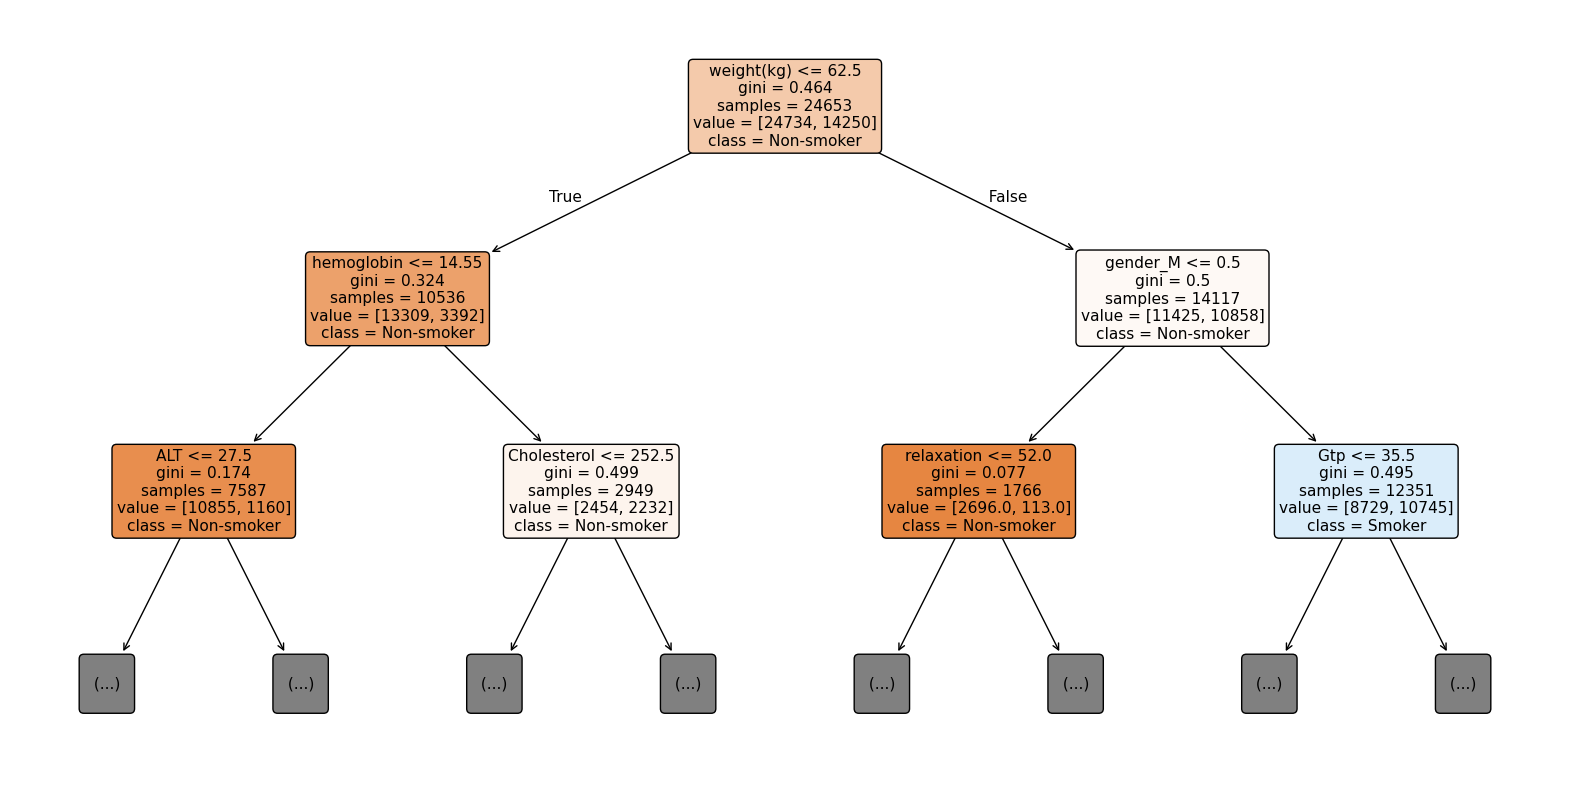

In [8]:
# Get a single tree from the random forest
tree = baseline_rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=['Non-smoker', 'Smoker'],
          filled=True,
          rounded=True,
          max_depth=2)  # Limiting depth for clarity
plt.show()

## Feature Engineering

In [9]:
def create_feature_engineering_dashboard(df_original, df_engineered):
    def plot_dropped_features(original):
        dropped_features = ['weight(kg)', 'waist(cm)', 'height(cm)', 'relaxation', 'triglyceride',
                            'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
                            'LDL', 'Cholesterol', 'Gtp', 'serum creatinine', 'AST', 'ALT']
        fig = make_subplots(rows=4, cols=4, subplot_titles=dropped_features)
        for i, feature in enumerate(dropped_features):
            row = i // 4 + 1
            col = i % 4 + 1
            fig.add_trace(go.Histogram(x=original[feature], name=feature), row=row, col=col)
        fig.update_layout(height=1200, width=1200, title_text="Dropped Features")
        return fig

    def plot_new_features(engineered):
        new_features = ['BMI', 'triglyceride_LDL', 'log_Gtp', 'log_serum_creatinine',
                        'ldl_cholesterol_ratio', 'ast_alt_ratio']
        fig = make_subplots(rows=2, cols=3, subplot_titles=new_features)
        for i, feature in enumerate(new_features):
            row = i // 3 + 1
            col = i % 3 + 1
            fig.add_trace(go.Histogram(x=engineered[feature], name=feature), row=row, col=col)
        fig.update_layout(height=800, width=1200, title_text="New and Engineered Features")
        return fig

    # Create tabs
    tab_titles = ['Dropped Features', 'New Features', 'Correlation Matrix']
    tab = widgets.Tab()
    tab.children = [widgets.Output() for _ in range(len(tab_titles))]
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)

    # Populate tabs
    with tab.children[0]:
        fig = plot_dropped_features(df_original)
        display(go.FigureWidget(fig))

    with tab.children[1]:
        fig = plot_new_features(df_engineered)
        display(go.FigureWidget(fig))

    with tab.children[2]:
        fig = plot_correlation_matrix(best_model, df_engineered, 'best_model')
        display(go.FigureWidget(fig))

    display(tab)

df_original = df.copy()

# Perform feature engineering
df_engineered = df.copy()
df_engineered['BMI'] = df_engineered['weight(kg)'] / (df_engineered['height(cm)'] / 100) ** 2
df_engineered['triglyceride_LDL'] = df_engineered['triglyceride'] * df_engineered['LDL']
df_engineered['log_Gtp'] = np.log(df_engineered['Gtp'] + 1)
df_engineered['log_serum_creatinine'] = np.log(df_engineered['serum creatinine'] + 1)
df_engineered['ldl_cholesterol_ratio'] = df_engineered['LDL'] / df_engineered['Cholesterol']
df_engineered['ast_alt_ratio'] = df_engineered['AST'] / df_engineered['ALT']

# Drop columns from the engineered dataframe
columns_to_drop = ['weight(kg)', 'waist(cm)', 'height(cm)', 'relaxation', 'triglyceride',
                   'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
                   'LDL', 'Cholesterol', 'Gtp', 'serum creatinine', 'AST', 'ALT']
df_engineered.drop(columns=columns_to_drop, inplace=True)

# Create and display the dashboard
create_feature_engineering_dashboard(df_original, df_engineered)

### Feature Engineering Changes

#### Dropped Features
- Individual eye/ear measurements: These showed low correlation with smoking status and were deemed less relevant for the prediction task.
- Basic body measurements (weight, height, waist): Replaced by the more comprehensive BMI metric.
- Individual lipid measurements: Consolidated into more informative ratios.

#### New Features
- **BMI (Body Mass Index)**: Standard health risk indicator known to be affected by smoking habits.
- **LDL/Cholesterol Ratio**: Potentially better indicator of cardiovascular risk than individual lipid levels.
- **AST/ALT Ratio**: Liver health indicator that may be influenced by smoking behavior, worth exploring.
- **Triglyceride-LDL Interaction**: Could capture complex lipid interactions that may be more indicative of smoking-related health impacts, worth exploring.
- **Log-transformed features**: Normalize right-skewed distributions for GTP and serum creatinine to potentially capture non-linear relationships with smoking status.

### Rationale and Potential Benefits

1. **Improved Model Accuracy**: These engineered features provide more informative inputs, potentially enhancing the model's ability to distinguish between smokers and non-smokers.

2. **Dimensionality Reduction**: Consolidating related features (individual body measurements into BMI) reduces noise and the potential risk of overfitting.

## Best Model Analysis and Comparison

In [10]:
# Create X including all original and engineered features, except the target
X_tuned = df_engineered.drop('smoking', axis=1)
y_tuned = df_engineered['smoking']

# Now split the processed and feature engineered data
X_train_tuned, X_test_tuned, y_train_tuned, y_test_tuned = train_test_split(X_tuned, y_tuned, test_size=0.2, random_state=42)

# Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test_tuned)
y_probs_tuned = best_model.predict_proba(X_test_tuned)[:, 1]

In [11]:
# Call the dashboard function, now with the tuned model
create_metrics_dashboard(models, X_test_baseline, y_test_baseline, y_probs, scores, best_model=best_model, X_test_tuned=X_test_tuned, y_test_tuned=y_test_tuned)

### Performance Metrics Comparison

| Metric    | Baseline RF (Original Features) | Tuned RF (Engineered Features) | % Change |
|-----------|--------------------------------|--------------------------------|----------|
| Accuracy  | 0.8206                         | 0.8285                         | +0.96%   |
| Precision | 0.7465                         | 0.7545                         | +1.07%   |
| Recall    | 0.7765                         | 0.7938                         | +2.23%   |
| F1 Score  | 0.7612                         | 0.7736                         | +1.63%   |
| ROC AUC   | 0.9064                         | 0.9174                         | +1.21%   |

### Model Training Takeaways

- The combination of feature engineering and model tuning led to improvements across all metrics, with the largest gain in recall (+2.23%).

- The engineered features, all derived from the original raw data, have contributed to these performance improvements. This includes ratios like BMI, lipid ratios, and log transformations.

- Both precision and recall saw improvements, indicating a more balanced model that's better at identifying smokers while reducing false positives.

- The increase in ROC AUC to 0.9174 (+1.21%) suggests enhanced ability to distinguish between smokers and non-smokers.

- Both RF models significantly outperform the Logistic Regression model, justifying the choice of Random Forest for this task.

### Implications of Feature Engineering

- Many of the raw data derived engineered features (like BMI and lipid ratios) are standard medical metrics, potentially making the model more interpretable and aligned with clinical understanding.

- The improvements show that the Random Forest algorithm benefited from these derived features, suggesting it can adapt to different representations of the same underlying information.


# Smoking Status Prediction Tool

## How to Use:

1. Adjust the sliders and dropdown menus to input different values for each health metric and demographic factor.
2. Click the "Predict Smoker Status" button after setting the values.
3. The tool will display:
   - The predicted status (Smoker or Non-smoker)
   - The probability of being a smoker (from 0 to 1)

## Important Notes:

- A probability close to 0.5 indicates uncertainty in the prediction.
- The default values are set to population averages, which may result in an uncertain prediction.
- Extreme or unrealistic input values may lead to less reliable predictions.
- Use the feature importance graph of the tuned model (see directly above, in descending order) to adjust factors that have the strongest influence on smoking prediction.

## Interpretation Guide:

- **Probability < 0.4**: The model predicts the individual is likely a non-smoker.
- **Probability 0.4 - 0.6**: The model is uncertain; other factors may need consideration.
- **Probability > 0.6**: The model predicts the individual is likely a smoker.

In [13]:
def create_prediction_tool(df_engineered, best_model, X_train_tuned):
    # Create sliders and dropdowns with enhanced descriptions
    age_slider = widgets.IntSlider(min=18, max=100, step=1, value=40, description='Age:')
    systolic_slider = widgets.IntSlider(min=80, max=250, step=1, value=120, description='Systolic BP:')
    fasting_blood_sugar_slider = widgets.FloatSlider(min=50, max=400, step=1, value=100, description='Fasting Blood Sugar (mg/dL):')
    cholesterol_slider = widgets.FloatSlider(min=100, max=400, step=1, value=200, description='Cholesterol (mg/dL):')
    hemoglobin_slider = widgets.FloatSlider(min=5, max=25, step=0.1, value=14, description='Hemoglobin (g/dL):')
    HDL_slider = widgets.FloatSlider(min=20, max=150, step=1, value=50, description='HDL (mg/dL):')
    LDL_slider = widgets.FloatSlider(min=50, max=300, step=1, value=100, description='LDL (mg/dL):')
    triglyceride_slider = widgets.FloatSlider(min=50, max=600, step=1, value=150, description='Triglycerides (mg/dL):')
    serum_creatinine_slider = widgets.FloatSlider(min=0.3, max=5.0, step=0.01, value=1.0, description='Serum Creatinine (mg/dL):')
    Gtp_slider = widgets.FloatSlider(min=10, max=300, step=1, value=30, description='GTP (U/L):')
    BMI_slider = widgets.FloatSlider(min=10, max=60, step=0.1, value=25, description='BMI:')
    ast_alt_ratio_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1, description='AST/ALT Ratio:')

    gender_dropdown = widgets.Dropdown(options=['Male', 'Female'], value='Male', description='Gender:')
    tartar_dropdown = widgets.Dropdown(options=['Y', 'N'], value='N', description='Tartar Present:')

    # Create a predict button
    predict_button = widgets.Button(description="Predict Smoker Status", style={'description_width': 'initial'})

    # Create an output widget to display results
    output = widgets.Output()

    def make_prediction(b):
        with output:
            clear_output()
            try:
                # Collect values from sliders and dropdowns
                input_data = pd.DataFrame({
                    'ID': [0],  # Placeholder ID
                    'age': [age_slider.value],
                    'systolic': [systolic_slider.value],
                    'fasting blood sugar': [fasting_blood_sugar_slider.value],
                    'Cholesterol': [cholesterol_slider.value],
                    'HDL': [HDL_slider.value],
                    'LDL': [LDL_slider.value],
                    'hemoglobin': [hemoglobin_slider.value],
                    'Urine protein': [1.0],  # Using a default value
                    'serum creatinine': [serum_creatinine_slider.value],
                    'Gtp': [Gtp_slider.value],
                    'dental caries': [0],  # Using a default value
                    'tartar': [1 if tartar_dropdown.value == 'Y' else 0],
                    'gender_M': [1 if gender_dropdown.value == 'Male' else 0],
                    'BMI': [BMI_slider.value],
                    'ast_alt_ratio': [ast_alt_ratio_slider.value],
                })

                # Add engineered features
                input_data['triglyceride_LDL'] = triglyceride_slider.value * input_data['LDL']
                input_data['log_Gtp'] = np.log(input_data['Gtp'] + 1)
                input_data['log_triglyceride_LDL'] = np.log(input_data['triglyceride_LDL'] + 1)
                input_data['log_serum_creatinine'] = np.log(input_data['serum creatinine'] + 1)
                input_data['log_fasting_blood_sugar'] = np.log(input_data['fasting blood sugar'] + 1)
                input_data['ldl_cholesterol_ratio'] = input_data['LDL'] / input_data['Cholesterol']

                # Ensure the input_data has the same columns as X_train_tuned (in the same order)
                input_data = input_data.reindex(columns=X_train_tuned.columns, fill_value=0)

                # Make prediction
                prediction = best_model.predict(input_data)
                probabilities = best_model.predict_proba(input_data)
                smoking_probability = probabilities[0][1]

                # Create Plotly gauge chart
                fig = go.Figure(go.Indicator(
                    mode = "gauge+number",
                    value = smoking_probability,
                    domain = {'x': [0, 1], 'y': [0, 1]},
                    title = {'text': "Smoking Probability"},
                    gauge = {
                        'axis': {'range': [0, 1]},
                        'bar': {'color': "darkblue"},
                        'steps' : [
                            {'range': [0, 0.5], 'color': "lightgreen"},
                            {'range': [0.5, 1], 'color': "lightcoral"}
                        ],
                        'threshold' : {
                            'line': {'color': "red", 'width': 4},
                            'thickness': 0.75,
                            'value': 0.5
                        }
                    }
                ))

                fig.update_layout(height=300, margin=dict(l=10, r=10, t=50, b=10))

                # Determine confidence level
                if smoking_probability > 0.8 or smoking_probability < 0.2:
                    confidence = "High"
                elif smoking_probability > 0.6 or smoking_probability < 0.4:
                    confidence = "Moderate"
                else:
                    confidence = "Low"

                # Display results
                display(HTML("<h3>Prediction Results</h3>"))
                display(HTML(f"<p><strong>Prediction:</strong> {'Smoker' if prediction[0] == 1 else 'Non-smoker'}</p>"))
                display(HTML(f"<p><strong>Probability of being a smoker:</strong> {smoking_probability:.2f}</p>"))
                display(HTML(f"<p><strong>Prediction Confidence:</strong> {confidence}</p>"))

                display(fig)

            except Exception as e:
                display(HTML(f"<p style='color: red;'>An error occurred: {str(e)}</p>"))
                import traceback
                display(HTML(f"<pre>{traceback.format_exc()}</pre>"))

    # Attach the function to the button
    predict_button.on_click(make_prediction)

    # Create a layout for the widgets
    input_widgets = widgets.VBox([
        widgets.HBox([age_slider, BMI_slider, systolic_slider]),
        widgets.HBox([cholesterol_slider, hemoglobin_slider, fasting_blood_sugar_slider]),
        widgets.HBox([HDL_slider, LDL_slider, triglyceride_slider]),
        widgets.HBox([serum_creatinine_slider, Gtp_slider, ast_alt_ratio_slider]),
        widgets.HBox([gender_dropdown, tartar_dropdown]),
        predict_button
    ])

    # Display the tool
    display(HTML("<h2>Smoker Status Prediction Tool</h2>"))
    display(HTML("<p>Adjust the sliders to input health data and click 'Predict Smoker Status'.</p>"))
    display(input_widgets)
    display(output)

# Call the function to create and display the prediction tool
create_prediction_tool(df_engineered, best_model, X_train_tuned)

Output()

In [14]:
print()
print()
print()